# 13 — MTL Architecture Variants

Eksperimen 4 modifikasi arsitektur Hierarchical Multi-Task Learning yang **belum pernah diuji**:

| Variant | Modifikasi | Status NB03-12 |
|---------|-----------|----------------|
| V1 | Label Smoothing (ls=0.1) | Belum pernah |
| V2 | Task-Specific Dropout (head=0.2) | Belum pernah |
| V3 | Task-Alternating Training | Belum pernah |
| V4 | Partial Layer Sharing (top 3 BERT layers) | Belum pernah |

**Model**: `indobenchmark/indobert-large-p2` (primary thesis model)
**Data**: Original only (augmentasi merugikan MTL di NB10)
**Baseline**: NB10 MT+Original (F1=0.7578), target > ST+Augmented (F1=0.7600)

**Hyperparameters** (identik NB10 kecuali modifikasi variant):
- 50 epoch, patience=10, LR BERT=2e-5, LR Head=1e-4
- Batch=4, GradAccum=4, Dropout=0.1, WD=0.01
- MTL: λ1=0.3, λ2=0.3, Phase1=3 epochs

In [1]:
import json
import os
import copy
import string
import time
import gc
from collections import Counter
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from torchcrf import CRF
from seqeval.metrics import (
    classification_report,
    f1_score as seq_f1_score,
    precision_score as seq_precision_score,
    recall_score as seq_recall_score,
)
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 120

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'PyTorch: {torch.__version__}')
print(f'Device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')

PyTorch: 2.5.1+cu121
Device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
VRAM: 8.0 GB


### 1. KONFIGURASI

In [2]:
# Paths
BASE_DIR = os.path.dirname(os.getcwd())
DATA_RAW_DIR = os.path.join(BASE_DIR, 'data', 'raw')
DATA_PROC_DIR = os.path.join(BASE_DIR, 'data', 'processed')
MODEL_DIR = os.path.join(BASE_DIR, 'models')
os.makedirs(MODEL_DIR, exist_ok=True)

BIEOS_PATH = os.path.join(DATA_PROC_DIR, 'train_data_bieos.json')
POS_LEX_PATH = os.path.join(DATA_RAW_DIR, 'indonesian_sentiment_lexicon_positive.tsv')
NEG_LEX_PATH = os.path.join(DATA_RAW_DIR, 'indonesian_sentiment_lexicon_negative.tsv')
NB10_CHECKPOINT = os.path.join(MODEL_DIR, 'checkpoint_extended_training.pt')

# Model
MODEL_NAME = 'indobenchmark/indobert-large-p2'
MAX_LENGTH = 128
PROJ_DIM = 256

# Training config (identik NB10)
BATCH_SIZE = 4
GRADIENT_ACCUMULATION = 4
NUM_EPOCHS = 50
LR_BERT = 2e-5
LR_HEAD = 1e-4
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01
MAX_GRAD_NORM = 1.0
TRAIN_RATIO = 0.85
DROPOUT = 0.1
IGNORE_INDEX = -100

# Multi-task specific
LAMBDA1 = 0.3
LAMBDA2 = 0.3
PHASE1_EPOCHS = 3
MAX_REL_POS = 20
PATIENCE = 10
SEED = 42

# Variant definitions
RUNS = [
    {'name': 'V1: Label Smoothing',      'variant': 'label_smoothing'},
    {'name': 'V2: Task Dropout',          'variant': 'task_dropout'},
    {'name': 'V3: Task-Alternating',      'variant': 'task_alternating'},
    {'name': 'V4: Partial Layer Sharing', 'variant': 'partial_sharing'},
]

# V4 config
SHARED_UNTIL = 20  # share layers 0-20, split 21-23

print(f'Model: {MODEL_NAME}')
print(f'Total variants: {len(RUNS)}')
print(f'NB10 checkpoint: {os.path.exists(NB10_CHECKPOINT)}')
for i, r in enumerate(RUNS):
    print(f'  {i+1}. {r["name"]}')

Model: indobenchmark/indobert-large-p2
Total variants: 4
NB10 checkpoint: True
  1. V1: Label Smoothing
  2. V2: Task Dropout
  3. V3: Task-Alternating
  4. V4: Partial Layer Sharing


### 2. LOAD DATA & TOKENIZER

In [3]:
with open(BIEOS_PATH, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

def load_lexicon(path):
    words = set()
    with open(path, 'r', encoding='utf-8') as f:
        next(f)
        for line in f:
            parts = line.strip().split('\t')
            if parts:
                word = parts[0].strip().lower()
                if ' ' not in word and len(word) > 1:
                    words.add(word)
    return words

pos_lexicon = load_lexicon(POS_LEX_PATH)
neg_lexicon = load_lexicon(NEG_LEX_PATH)
overlap = pos_lexicon & neg_lexicon
pos_lexicon -= overlap
neg_lexicon -= overlap

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f'Original data: {len(raw_data)}')
print(f'Pos lexicon: {len(pos_lexicon)} | Neg lexicon: {len(neg_lexicon)}')

Original data: 2451
Pos lexicon: 2288 | Neg lexicon: 5025


### 3. LABELS & DATA PREPARATION

In [4]:
ate_labels = ['O', 'B', 'I', 'E', 'S']
sld_labels = ['O', 'POS', 'NEG']
asd_labels = ['O', 'POS', 'NEG', 'NEU']
bieos_labels = ['O', 'B-NEG', 'B-NEU', 'B-POS', 'E-NEG', 'E-NEU', 'E-POS',
                'I-NEG', 'I-NEU', 'I-POS', 'S-NEG', 'S-NEU', 'S-POS']

ate_label2id = {l: i for i, l in enumerate(ate_labels)}
sld_label2id = {l: i for i, l in enumerate(sld_labels)}
asd_label2id = {l: i for i, l in enumerate(asd_labels)}
bieos_label2id = {l: i for i, l in enumerate(bieos_labels)}
bieos_id2label = {i: l for l, i in bieos_label2id.items()}


def _compute_word_prior(raw_data):
    word_ate_freq = {}
    for d in raw_data:
        for tok, lab in zip(d['tokens'], d['labels']):
            tok_lower = tok.lower()
            if tok_lower not in word_ate_freq:
                word_ate_freq[tok_lower] = [0] * len(ate_labels)
            if lab == 'O':
                word_ate_freq[tok_lower][ate_label2id['O']] += 1
            else:
                word_ate_freq[tok_lower][ate_label2id[lab.split('-')[0]]] += 1
    default_prior = [1.0] + [0.0] * (len(ate_labels) - 1)
    word_prior = {}
    for word, counts in word_ate_freq.items():
        total = sum(counts)
        word_prior[word] = [c / total for c in counts] if total > 0 else default_prior
    return word_prior, default_prior


def _tokenize_mt_samples(raw_data, tokenizer, word_prior, default_prior, pos_lexicon, neg_lexicon):
    all_input_ids, all_attention_mask = [], []
    all_ate, all_sld, all_asd, all_bieos, all_crf, all_prior = [], [], [], [], [], []

    for d in raw_data:
        tokens, labels = d['tokens'], d['labels']
        enc = tokenizer(tokens, is_split_into_words=True,
                        max_length=MAX_LENGTH, padding='max_length',
                        truncation=True, return_tensors='pt')
        word_ids = enc.word_ids(batch_index=0)

        ate_w, sld_w, asd_w = [], [], []
        for tok, lab in zip(tokens, labels):
            if lab == 'O':
                ate_w.append('O'); asd_w.append('O')
            else:
                prefix, sentiment = lab.split('-', 1)
                ate_w.append(prefix); asd_w.append(sentiment)
            t_clean = tok.lower().strip(string.punctuation)
            if t_clean in pos_lexicon:
                sld_w.append('POS')
            elif t_clean in neg_lexicon:
                sld_w.append('NEG')
            else:
                sld_w.append('O')

        ate_a, sld_a, asd_a, bieos_a, crf_a, prior_a = [], [], [], [], [], []
        prev_wid = None
        for wid in word_ids:
            if wid is None:
                ate_a.append(IGNORE_INDEX); sld_a.append(IGNORE_INDEX)
                asd_a.append(IGNORE_INDEX); bieos_a.append(IGNORE_INDEX)
                crf_a.append(0); prior_a.append(default_prior)
            elif wid != prev_wid:
                if wid < len(tokens):
                    ate_a.append(ate_label2id[ate_w[wid]])
                    sld_a.append(sld_label2id[sld_w[wid]])
                    asd_a.append(asd_label2id[asd_w[wid]])
                    bieos_a.append(bieos_label2id[labels[wid]])
                    crf_a.append(bieos_label2id[labels[wid]])
                    prior_a.append(word_prior.get(tokens[wid].lower(), default_prior))
                else:
                    ate_a.append(IGNORE_INDEX); sld_a.append(IGNORE_INDEX)
                    asd_a.append(IGNORE_INDEX); bieos_a.append(IGNORE_INDEX)
                    crf_a.append(0); prior_a.append(default_prior)
            else:
                ate_a.append(IGNORE_INDEX); sld_a.append(IGNORE_INDEX)
                asd_a.append(IGNORE_INDEX); bieos_a.append(IGNORE_INDEX)
                crf_a.append(bieos_label2id[labels[wid]] if wid < len(tokens) else 0)
                prior_a.append(word_prior.get(tokens[wid].lower(), default_prior) if wid < len(tokens) else default_prior)
            prev_wid = wid

        all_input_ids.append(enc['input_ids'].squeeze(0))
        all_attention_mask.append(enc['attention_mask'].squeeze(0))
        all_ate.append(torch.tensor(ate_a, dtype=torch.long))
        all_sld.append(torch.tensor(sld_a, dtype=torch.long))
        all_asd.append(torch.tensor(asd_a, dtype=torch.long))
        all_bieos.append(torch.tensor(bieos_a, dtype=torch.long))
        all_crf.append(torch.tensor(crf_a, dtype=torch.long))
        all_prior.append(torch.tensor(prior_a, dtype=torch.float))

    return {
        'input_ids': torch.stack(all_input_ids),
        'attention_mask': torch.stack(all_attention_mask),
        'ate_labels': torch.stack(all_ate),
        'sld_labels': torch.stack(all_sld),
        'asd_labels': torch.stack(all_asd),
        'bieos_labels': torch.stack(all_bieos),
        'crf_labels': torch.stack(all_crf),
        'prior_probs': torch.stack(all_prior),
    }


print('Preparing data...')
word_prior, default_prior = _compute_word_prior(raw_data)
mt_data = _tokenize_mt_samples(raw_data, tokenizer, word_prior, default_prior, pos_lexicon, neg_lexicon)
print(f'Tokenized: {mt_data["input_ids"].shape[0]} samples')

Preparing data...
Tokenized: 2451 samples


### 4. DATASET & MODEL CLASSES

In [5]:
class ABSADataset(Dataset):
    def __init__(self, data_dict, indices):
        self.data = {k: v[indices] for k, v in data_dict.items()}
    def __len__(self):
        return self.data['input_ids'].size(0)
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


# --- Cross-Attention (shared by all MTL variants) ---
class CrossAttentionASD(nn.Module):
    def __init__(self, dim, max_relative_position=20):
        super().__init__()
        self.max_rel_pos = max_relative_position
        self.pos_embedding = nn.Embedding(2 * max_relative_position + 1, dim)
        self.W_ae = nn.Linear(dim, dim, bias=False)
        self.W_sl = nn.Linear(dim, dim, bias=False)
        self.W_pos = nn.Linear(dim, dim, bias=False)
        self.bias = nn.Parameter(torch.zeros(dim))
        self.w_s = nn.Linear(dim, 1, bias=False)

    def forward(self, h_ae, h_sl, mask=None):
        batch, seq_len, dim = h_ae.shape
        pos = torch.arange(seq_len, device=h_ae.device)
        rel_pos = (pos.unsqueeze(0) - pos.unsqueeze(1)).clamp(
            -self.max_rel_pos, self.max_rel_pos) + self.max_rel_pos
        p_ij = self.pos_embedding(rel_pos)
        s_ae = self.W_ae(h_ae)
        s_sl = self.W_sl(h_sl)
        s_pos = self.W_pos(p_ij)
        combined = s_ae.unsqueeze(2) + s_sl.unsqueeze(1) + s_pos.unsqueeze(0) + self.bias
        scores = self.w_s(torch.tanh(combined)).squeeze(-1)
        if mask is not None:
            scores = scores.masked_fill(~mask.unsqueeze(1), float('-inf'))
        attn_weights = torch.softmax(scores, dim=-1)
        return torch.bmm(attn_weights, h_sl)


# --- V0: Base MTL (identical to NB10, for reference) ---
class HierarchicalMultiTaskABSA(nn.Module):
    def __init__(self, model_name, num_ate, num_sld, num_asd, num_final,
                 proj_dim=256, dropout=0.1, max_relative_position=20,
                 lambda1=0.3, lambda2=0.3, label_smoothing=0.0, head_dropout=None):
        super().__init__()
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.num_sld = num_sld
        self.num_asd = num_asd
        self.label_smoothing = label_smoothing
        hd = head_dropout if head_dropout is not None else dropout
        self.bert = AutoModel.from_pretrained(model_name, use_safetensors=True, low_cpu_mem_usage=True)
        bert_dim = self.bert.config.hidden_size
        self.ate_proj = nn.Sequential(nn.Linear(bert_dim + num_ate, proj_dim), nn.GELU(), nn.Dropout(hd))
        self.ate_classifier = nn.Linear(proj_dim, num_ate)
        self.sld_proj = nn.Sequential(nn.Linear(bert_dim, proj_dim), nn.GELU(), nn.Dropout(hd))
        self.sld_classifier = nn.Linear(proj_dim, num_sld)
        self.cross_attention = CrossAttentionASD(proj_dim, max_relative_position)
        self.asd_classifier = nn.Linear(proj_dim, num_asd)
        self.final_proj = nn.Sequential(nn.Linear(proj_dim * 2, proj_dim), nn.GELU(), nn.Dropout(hd))
        self.final_emission = nn.Linear(proj_dim, num_final)
        self.crf = CRF(num_final, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask, prior_probs=None,
                ate_labels=None, sld_labels=None, asd_labels=None, crf_labels=None, **kwargs):
        h = self.dropout(self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state)
        if prior_probs is not None:
            h_with_prior = torch.cat([h, prior_probs], dim=-1)
        else:
            h_with_prior = torch.cat([h, torch.zeros(*h.shape[:-1], self.ate_classifier.out_features, device=h.device)], dim=-1)
        h_ae = self.ate_proj(h_with_prior)
        ate_logits = self.ate_classifier(h_ae)
        h_sl = self.sld_proj(h)
        sld_logits = self.sld_classifier(h_sl)
        mask = attention_mask.bool()
        h_sd = self.cross_attention(h_ae, h_sl, mask=mask)
        asd_logits = self.asd_classifier(h_sd)
        h_concat = torch.cat([h_ae, h_sd], dim=-1)
        emissions = self.final_emission(self.final_proj(h_concat))
        outputs = {'ate_logits': ate_logits, 'sld_logits': sld_logits,
                   'asd_logits': asd_logits, 'emissions': emissions}
        if ate_labels is not None:
            ce = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX, label_smoothing=self.label_smoothing)
            loss_ate = ce(ate_logits.view(-1, ate_logits.size(-1)), ate_labels.view(-1))
            loss_sld = ce(sld_logits.view(-1, sld_logits.size(-1)), sld_labels.view(-1))
            loss_asd = ce(asd_logits.view(-1, asd_logits.size(-1)), asd_labels.view(-1))
            loss_crf = -self.crf(emissions.float(), crf_labels, mask=mask, reduction='mean')
            outputs['loss'] = self.lambda1 * (loss_ate + loss_sld) + self.lambda2 * loss_asd + loss_crf
            outputs['losses'] = {
                'ate': loss_ate.detach(), 'sld': loss_sld.detach(),
                'asd': loss_asd.detach(), 'crf': loss_crf.detach()}
            # Non-detached losses for task-alternating training (V3)
            outputs['losses_raw'] = {
                'ate': loss_ate, 'sld': loss_sld,
                'asd': loss_asd, 'crf': loss_crf}
        return outputs

    def decode(self, emissions, attention_mask):
        return self.crf.decode(emissions.float(), mask=attention_mask.bool())

    def apply_sentiment_connection(self):
        with torch.no_grad():
            n = min(self.num_sld, self.num_asd)
            self.asd_classifier.weight.data[:n].copy_(self.sld_classifier.weight.data[:n])
            self.asd_classifier.bias.data[:n].copy_(self.sld_classifier.bias.data[:n])


# --- V4: Partial Layer Sharing ---
class PartialSharingMTL(nn.Module):
    """Split top BERT layers into aspect and sentiment branches."""
    def __init__(self, model_name, num_ate, num_sld, num_asd, num_final,
                 proj_dim=256, dropout=0.1, max_relative_position=20,
                 lambda1=0.3, lambda2=0.3, shared_until=20):
        super().__init__()
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.num_sld = num_sld
        self.num_asd = num_asd

        # Load full BERT with eager attention (SDPA incompatible with manual layer calls)
        full_bert = AutoModel.from_pretrained(
            model_name, use_safetensors=True, low_cpu_mem_usage=True,
            attn_implementation='eager')
        bert_dim = full_bert.config.hidden_size
        num_layers = len(full_bert.encoder.layer)

        self.embeddings = full_bert.embeddings
        self.shared_layers = nn.ModuleList(full_bert.encoder.layer[:shared_until + 1])
        self.aspect_layers = nn.ModuleList(
            [copy.deepcopy(full_bert.encoder.layer[i]) for i in range(shared_until + 1, num_layers)])
        self.sentiment_layers = nn.ModuleList(
            [copy.deepcopy(full_bert.encoder.layer[i]) for i in range(shared_until + 1, num_layers)])
        del full_bert
        gc.collect()

        # Task heads (same as base MTL)
        self.ate_proj = nn.Sequential(nn.Linear(bert_dim + num_ate, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.ate_classifier = nn.Linear(proj_dim, num_ate)
        self.sld_proj = nn.Sequential(nn.Linear(bert_dim, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.sld_classifier = nn.Linear(proj_dim, num_sld)
        self.cross_attention = CrossAttentionASD(proj_dim, max_relative_position)
        self.asd_classifier = nn.Linear(proj_dim, num_asd)
        self.final_proj = nn.Sequential(nn.Linear(proj_dim * 2, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.final_emission = nn.Linear(proj_dim, num_final)
        self.crf = CRF(num_final, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def _get_extended_mask(self, attention_mask):
        """Convert attention_mask to extended format for BERT layers."""
        ext = attention_mask[:, None, None, :].float()
        ext = (1.0 - ext) * -10000.0
        return ext

    def forward(self, input_ids, attention_mask, prior_probs=None,
                ate_labels=None, sld_labels=None, asd_labels=None, crf_labels=None, **kwargs):
        ext_mask = self._get_extended_mask(attention_mask)

        # Shared layers
        # NOTE: BertLayer.forward() returns a single tensor (not tuple) in newer transformers
        h = self.embeddings(input_ids)
        for layer in self.shared_layers:
            h = layer(h, ext_mask)

        # Aspect branch (top layers)
        h_asp = h
        for layer in self.aspect_layers:
            h_asp = layer(h_asp, ext_mask)
        h_asp = self.dropout(h_asp)

        # Sentiment branch (top layers)
        h_sent = h
        for layer in self.sentiment_layers:
            h_sent = layer(h_sent, ext_mask)
        h_sent = self.dropout(h_sent)

        # ATE: uses aspect branch
        if prior_probs is not None:
            h_with_prior = torch.cat([h_asp, prior_probs], dim=-1)
        else:
            h_with_prior = torch.cat([h_asp, torch.zeros(*h_asp.shape[:-1], self.ate_classifier.out_features, device=h_asp.device)], dim=-1)
        h_ae = self.ate_proj(h_with_prior)
        ate_logits = self.ate_classifier(h_ae)

        # SLD: uses sentiment branch
        h_sl = self.sld_proj(h_sent)
        sld_logits = self.sld_classifier(h_sl)

        # ASD: cross-attention from aspect to sentiment
        mask = attention_mask.bool()
        h_sd = self.cross_attention(h_ae, h_sl, mask=mask)
        asd_logits = self.asd_classifier(h_sd)

        # CRF: concat aspect + sentiment features
        h_concat = torch.cat([h_ae, h_sd], dim=-1)
        emissions = self.final_emission(self.final_proj(h_concat))

        outputs = {'ate_logits': ate_logits, 'sld_logits': sld_logits,
                   'asd_logits': asd_logits, 'emissions': emissions}

        if ate_labels is not None:
            ce = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
            loss_ate = ce(ate_logits.view(-1, ate_logits.size(-1)), ate_labels.view(-1))
            loss_sld = ce(sld_logits.view(-1, sld_logits.size(-1)), sld_labels.view(-1))
            loss_asd = ce(asd_logits.view(-1, asd_logits.size(-1)), asd_labels.view(-1))
            loss_crf = -self.crf(emissions.float(), crf_labels, mask=mask, reduction='mean')
            outputs['loss'] = self.lambda1 * (loss_ate + loss_sld) + self.lambda2 * loss_asd + loss_crf
            outputs['losses'] = {
                'ate': loss_ate.detach(), 'sld': loss_sld.detach(),
                'asd': loss_asd.detach(), 'crf': loss_crf.detach()}
        return outputs

    def decode(self, emissions, attention_mask):
        return self.crf.decode(emissions.float(), mask=attention_mask.bool())

    def apply_sentiment_connection(self):
        with torch.no_grad():
            n = min(self.num_sld, self.num_asd)
            self.asd_classifier.weight.data[:n].copy_(self.sld_classifier.weight.data[:n])
            self.asd_classifier.bias.data[:n].copy_(self.sld_classifier.bias.data[:n])


# Parameter count check
def count_params(model):
    return sum(p.numel() for p in model.parameters())

print('Model classes defined.')
print(f'\nParameter counts:')
_args = dict(model_name=MODEL_NAME, num_ate=len(ate_labels), num_sld=len(sld_labels),
             num_asd=len(asd_labels), num_final=len(bieos_labels),
             proj_dim=PROJ_DIM, dropout=DROPOUT, max_relative_position=MAX_REL_POS)
_m0 = HierarchicalMultiTaskABSA(**_args)
print(f'  Base MTL (V0/V1/V2/V3): {count_params(_m0)/1e6:.1f}M')
del _m0
_m4 = PartialSharingMTL(**_args, shared_until=SHARED_UNTIL)
print(f'  Partial Sharing (V4):    {count_params(_m4)/1e6:.1f}M (shared={SHARED_UNTIL+1} layers, split={24-SHARED_UNTIL-1} layers)')
del _m4
gc.collect()
torch.cuda.empty_cache()

Model classes defined.

Parameter counts:


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

  Base MTL (V0/V1/V2/V3): 336.0M


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

  Partial Sharing (V4):    372.8M (shared=21 layers, split=3 layers)


### 5. TRAINING & EVALUATION FUNCTIONS

In [6]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds, all_true = [], []
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            total_loss += outputs['loss'].item()
            preds = model.decode(outputs['emissions'], batch['attention_mask'])
            bieos_lbl = batch['bieos_labels']
            for i in range(len(preds)):
                pred_seq, true_seq = [], []
                for j in range(len(preds[i])):
                    if bieos_lbl[i][j].item() != IGNORE_INDEX:
                        pred_seq.append(bieos_id2label[preds[i][j]])
                        true_seq.append(bieos_id2label[bieos_lbl[i][j].item()])
                all_preds.append(pred_seq)
                all_true.append(true_seq)
    avg_loss = total_loss / len(dataloader)
    f1 = seq_f1_score(all_true, all_preds, zero_division=0)
    precision = seq_precision_score(all_true, all_preds, zero_division=0)
    recall = seq_recall_score(all_true, all_preds, zero_division=0)
    return avg_loss, f1, precision, recall, all_true, all_preds


def fmt_time(seconds):
    if seconds < 60:
        return f'{seconds:.0f}s'
    elif seconds < 3600:
        return f'{seconds/60:.1f}m'
    else:
        h = int(seconds // 3600)
        m = int((seconds % 3600) // 60)
        return f'{h}h{m:02d}m'


def train_model(model, train_loader, val_loader, device, num_epochs, patience,
                phase1_epochs=0, desc_prefix='', run_idx=0, total_runs=4,
                global_start_time=None, task_alternating=False):
    # Separate BERT params from head params
    # For PartialSharingMTL, BERT params include shared_layers, aspect_layers, sentiment_layers, embeddings
    bert_param_names = {'embeddings', 'shared_layers', 'aspect_layers', 'sentiment_layers', 'bert'}
    bert_params, head_params = [], []
    for n, p in model.named_parameters():
        if any(n.startswith(bp) for bp in bert_param_names):
            bert_params.append(p)
        else:
            head_params.append(p)

    total_epochs = phase1_epochs + num_epochs
    total_steps = (len(train_loader) // GRADIENT_ACCUMULATION) * total_epochs
    warmup_steps = int(total_steps * WARMUP_RATIO)

    optimizer = torch.optim.AdamW([
        {'params': bert_params, 'lr': LR_BERT},
        {'params': head_params, 'lr': LR_HEAD},
    ], weight_decay=WEIGHT_DECAY)
    scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    best_f1 = 0
    best_epoch = 0
    patience_counter = 0
    best_state = None
    has_subtasks = hasattr(model, 'apply_sentiment_connection')
    history = {'train_loss': [], 'val_loss': [], 'val_f1': [], 'val_precision': [], 'val_recall': []}
    if has_subtasks:
        history.update({'loss_ate': [], 'loss_sld': [], 'loss_asd': [], 'loss_crf': []})
    epoch_times = []

    def elapsed_total_str():
        if global_start_time is not None:
            return f' | Elapsed: {fmt_time(time.time() - global_start_time)}'
        return ''

    def run_epoch(epoch_num, epoch_label, use_alternating=False):
        model.train()
        epoch_loss = 0
        epoch_comp = {'ate': 0, 'sld': 0, 'asd': 0, 'crf': 0} if has_subtasks else None
        optimizer.zero_grad()
        pbar = tqdm(enumerate(train_loader), total=len(train_loader),
                    desc=f'  {desc_prefix} {epoch_label}', leave=False)
        for step, batch in pbar:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            
            # Task-alternating: recompute loss using only subset of tasks
            # Use losses_raw (non-detached) so gradients flow correctly
            if use_alternating and 'losses_raw' in outputs:
                losses_raw = outputs['losses_raw']
                if step % 2 == 0:
                    # Even steps: aspect + lexicon focus
                    alt_loss = LAMBDA1 * (losses_raw['ate'] + losses_raw['sld'])
                else:
                    # Odd steps: sentiment + joint focus
                    alt_loss = LAMBDA2 * losses_raw['asd'] + losses_raw['crf']
                loss = alt_loss / GRADIENT_ACCUMULATION
            else:
                loss = outputs['loss'] / GRADIENT_ACCUMULATION
            
            loss.backward()
            if (step + 1) % GRADIENT_ACCUMULATION == 0 or (step + 1) == len(train_loader):
                torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
            epoch_loss += outputs['loss'].item()
            if epoch_comp is not None and 'losses' in outputs:
                for k in epoch_comp:
                    epoch_comp[k] += outputs['losses'][k].item()
            pbar.set_postfix({'loss': f'{epoch_loss/(step+1):.4f}'})
        pbar.close()
        n = len(train_loader)
        avg_comp = {k: v / n for k, v in epoch_comp.items()} if epoch_comp else None
        return epoch_loss / n, avg_comp

    def subtask_str(comp):
        if comp is not None:
            return (f'\n      ATE:{comp["ate"]:.3f}  SLD:{comp["sld"]:.3f}  '
                    f'ASD:{comp["asd"]:.3f}  CRF:{comp["crf"]:.3f}')
        return ''

    # Phase 1 (SLD pre-training, always joint even for V3)
    if phase1_epochs > 0 and has_subtasks:
        for ep in range(phase1_epochs):
            ep_t0 = time.time()
            train_loss, comp = run_epoch(ep + 1, f'P1 {ep+1}/{phase1_epochs}', use_alternating=False)
            val_loss, val_f1, val_p, val_r, _, _ = evaluate(model, val_loader, device)
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['val_f1'].append(val_f1)
            history['val_precision'].append(val_p)
            history['val_recall'].append(val_r)
            if comp:
                for k in comp:
                    history[f'loss_{k}'].append(comp[k])
            ep_elapsed = time.time() - ep_t0
            epoch_times.append(ep_elapsed)
            done_ep = len(epoch_times)
            avg_ep = sum(epoch_times) / done_ep
            remaining_ep = total_epochs - done_ep
            eta_run = avg_ep * remaining_ep
            remaining_runs = total_runs - run_idx - 1
            eta_total = eta_run + (remaining_runs * avg_ep * total_epochs)
            print(f'    P1 {ep+1}/{phase1_epochs} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | '
                  f'F1: {val_f1:.4f} P: {val_p:.4f} R: {val_r:.4f} | {fmt_time(ep_elapsed)}/ep | '
                  f'ETA run: {fmt_time(eta_run)} | ETA all: {fmt_time(eta_total)}'
                  f'{elapsed_total_str()}{subtask_str(comp)}', flush=True)
        model.apply_sentiment_connection()
        print(f'    Sentiment Connection applied', flush=True)

    # Main training (V3 uses task_alternating here)
    for ep in range(num_epochs):
        global_ep = phase1_epochs + ep + 1
        ep_t0 = time.time()
        train_loss, comp = run_epoch(global_ep, f'Ep {global_ep}/{total_epochs}',
                                     use_alternating=task_alternating)
        val_loss, val_f1, val_p, val_r, _, _ = evaluate(model, val_loader, device)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
        history['val_precision'].append(val_p)
        history['val_recall'].append(val_r)
        if comp:
            for k in comp:
                history[f'loss_{k}'].append(comp[k])
        ep_elapsed = time.time() - ep_t0
        epoch_times.append(ep_elapsed)

        improved = val_f1 > best_f1
        if improved:
            best_f1 = val_f1
            best_epoch = global_ep
            patience_counter = 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1

        done_ep = len(epoch_times)
        avg_ep = sum(epoch_times) / done_ep
        remaining_ep = total_epochs - done_ep
        if patience_counter > 0:
            remaining_ep = min(remaining_ep, patience - patience_counter)
        eta_run = avg_ep * max(remaining_ep, 0)
        remaining_runs = total_runs - run_idx - 1
        eta_total = eta_run + (remaining_runs * avg_ep * total_epochs)

        print(f'    Ep {global_ep:2d}/{total_epochs} | Train: {train_loss:.4f} | '
              f'Val: {val_loss:.4f} | F1: {val_f1:.4f} P: {val_p:.4f} R: {val_r:.4f} '
              f'{"*" if improved else " "} | {fmt_time(ep_elapsed)}/ep | '
              f'ETA run: {fmt_time(eta_run)} | ETA all: {fmt_time(eta_total)}'
              f'{elapsed_total_str()}{subtask_str(comp)}', flush=True)

        if patience_counter >= patience:
            print(f'    Early stopped at epoch {global_ep}', flush=True)
            break

    if best_state is not None:
        model.load_state_dict(best_state)
    _, final_f1, final_p, final_r, all_true, all_preds = evaluate(model, val_loader, device)
    report = classification_report(all_true, all_preds, zero_division=0)

    return {
        'best_f1': best_f1,
        'best_epoch': best_epoch,
        'epochs_trained': len(history['val_f1']),
        'history': history,
        'report': report,
        'val_true': all_true,
        'val_preds': all_preds,
    }


print('Training functions defined.')

Training functions defined.


### 6. TRAINING LOOP

4 variant runs + load NB10 baselines. Original data only.

In [7]:
# Load NB10 baselines
nb10 = torch.load(NB10_CHECKPOINT, weights_only=False)
nb10_results = nb10['results']
print('NB10 baselines:')
for name in ['MT + Original', 'ST + Original', 'ST + Augmented']:
    print(f'  {name}: F1={nb10_results[name]["best_f1"]:.4f}')

# Load intermediate results (resume from V1-V3 if already completed)
INTERMEDIATE_PATH = os.path.join(MODEL_DIR, 'mtl_variants_intermediate.pt')
variant_results = {}
if os.path.exists(INTERMEDIATE_PATH):
    prev_results = torch.load(INTERMEDIATE_PATH, weights_only=False)
    print(f'\nLoaded {len(prev_results)} previous results from intermediate checkpoint:')
    for name, r in prev_results.items():
        print(f'  {name}: F1={r["best_f1"]:.4f} (ep {r["best_epoch"]})')
        variant_results[name] = r

# Prepare data split (same seed as NB10)
total_orig = len(raw_data)
orig_indices = torch.randperm(total_orig, generator=torch.Generator().manual_seed(SEED))
orig_split = int(total_orig * TRAIN_RATIO)

train_ds = ABSADataset(mt_data, orig_indices[:orig_split])
val_ds = ABSADataset(mt_data, orig_indices[orig_split:])

# Filter runs: skip already-completed variants
remaining_runs = [r for r in RUNS if r['name'] not in variant_results]
print(f'\nData split: train={len(train_ds)}, val={len(val_ds)}')
print(f'Total variants: {len(RUNS)} | Already completed: {len(RUNS) - len(remaining_runs)} | To run: {len(remaining_runs)}')
if remaining_runs:
    for r in remaining_runs:
        print(f'  -> {r["name"]}')
print()

run_counter = 0
total_runs = len(remaining_runs)
global_start = time.time()
run_times = []

for run_cfg in remaining_runs:
    run_name = run_cfg['name']
    variant = run_cfg['variant']

    elapsed_so_far = time.time() - global_start
    print(f'\n{"#"*60}')
    print(f'RUN {run_counter+1}/{total_runs}: {run_name}')
    print(f'{datetime.now().strftime("%H:%M:%S")} | Elapsed: {fmt_time(elapsed_so_far)}')
    print(f'{"#"*60}')

    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE * 2)

    # Create model based on variant
    model_kwargs = dict(
        model_name=MODEL_NAME, num_ate=len(ate_labels), num_sld=len(sld_labels),
        num_asd=len(asd_labels), num_final=len(bieos_labels),
        proj_dim=PROJ_DIM, dropout=DROPOUT, max_relative_position=MAX_REL_POS,
        lambda1=LAMBDA1, lambda2=LAMBDA2,
    )
    task_alt = False

    if variant == 'label_smoothing':
        model = HierarchicalMultiTaskABSA(**model_kwargs, label_smoothing=0.1).to(device)
        print(f'  V1: label_smoothing=0.1')
    elif variant == 'task_dropout':
        model = HierarchicalMultiTaskABSA(**model_kwargs, head_dropout=0.2).to(device)
        print(f'  V2: head_dropout=0.2 (BERT dropout=0.1)')
    elif variant == 'task_alternating':
        model = HierarchicalMultiTaskABSA(**model_kwargs).to(device)
        task_alt = True
        print(f'  V3: task-alternating (even=ATE+SLD, odd=ASD+CRF)')
    elif variant == 'partial_sharing':
        model = PartialSharingMTL(**model_kwargs, shared_until=SHARED_UNTIL).to(device)
        print(f'  V4: partial sharing (shared layers 0-{SHARED_UNTIL}, split {SHARED_UNTIL+1}-23)')

    n_params = count_params(model)
    print(f'  Train: {len(train_ds)} | Val: {len(val_ds)} | Params: {n_params/1e6:.1f}M')

    t0 = time.time()
    result = train_model(
        model, train_loader, val_loader, device,
        num_epochs=NUM_EPOCHS - PHASE1_EPOCHS, patience=PATIENCE,
        phase1_epochs=PHASE1_EPOCHS,
        desc_prefix=run_name[:6],
        run_idx=run_counter, total_runs=total_runs,
        global_start_time=global_start,
        task_alternating=task_alt,
    )
    result['run_name'] = run_name
    result['variant'] = variant
    result['params_m'] = n_params / 1e6
    result['elapsed_min'] = (time.time() - t0) / 60
    variant_results[run_name] = result
    run_times.append(time.time() - t0)
    run_counter += 1

    avg_run = sum(run_times) / len(run_times)
    remaining = total_runs - run_counter
    print(f'  >> {run_name}: F1={result["best_f1"]:.4f} (ep {result["best_epoch"]}) | '
          f'Run: {fmt_time(run_times[-1])} | Remaining: {remaining} runs ~{fmt_time(avg_run * remaining)}')

    del model, train_loader, val_loader
    gc.collect()
    torch.cuda.empty_cache()

    # Intermediate save
    torch.save(variant_results, INTERMEDIATE_PATH)

total_elapsed = time.time() - global_start
print(f'\n{"="*60}')
if remaining_runs:
    print(f'ALL REMAINING VARIANTS COMPLETED at {datetime.now().strftime("%H:%M:%S")}')
    print(f'Time for this session: {fmt_time(total_elapsed)}')
else:
    print(f'ALL VARIANTS ALREADY COMPLETED (loaded from checkpoint)')
print(f'Total results: {len(variant_results)} variants')
print(f'{"="*60}')

NB10 baselines:
  MT + Original: F1=0.7578
  ST + Original: F1=0.7558
  ST + Augmented: F1=0.7600

Loaded 3 previous results from intermediate checkpoint:
  V1: Label Smoothing: F1=0.7421 (ep 13)
  V2: Task Dropout: F1=0.7493 (ep 35)
  V3: Task-Alternating: F1=0.7392 (ep 10)

Data split: train=2083, val=368
Total variants: 4 | Already completed: 3 | To run: 1
  -> V4: Partial Layer Sharing


############################################################
RUN 1/1: V4: Partial Layer Sharing
23:49:27 | Elapsed: 0s
############################################################


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

  V4: partial sharing (shared layers 0-20, split 21-23)
  Train: 2083 | Val: 368 | Params: 372.8M


  V4: Pa P1 1/3:   0%|          | 0/521 [00:00<?, ?it/s]

    P1 1/3 | Train: 46.6993 | Val: 19.1426 | F1: 0.0000 P: 0.0000 R: 0.0000 | 3.8m/ep | ETA run: 3h05m | ETA all: 3h05m | Elapsed: 3.9m
      ATE:1.246  SLD:0.962  ASD:1.385  CRF:45.621


  V4: Pa P1 2/3:   0%|          | 0/521 [00:00<?, ?it/s]

    P1 2/3 | Train: 16.6111 | Val: 12.1432 | F1: 0.3994 P: 0.4238 R: 0.3777 | 3.8m/ep | ETA run: 3h01m | ETA all: 3h01m | Elapsed: 7.7m
      ATE:0.591  SLD:0.782  ASD:0.608  CRF:16.017


  V4: Pa P1 3/3:   0%|          | 0/521 [00:00<?, ?it/s]

    P1 3/3 | Train: 10.9353 | Val: 8.6954 | F1: 0.5364 P: 0.5237 R: 0.5497 | 3.8m/ep | ETA run: 2h57m | ETA all: 2h57m | Elapsed: 11.4m
      ATE:0.400  SLD:0.767  ASD:0.548  CRF:10.421
    Sentiment Connection applied


  V4: Pa Ep 4/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  4/50 | Train: 7.2939 | Val: 7.0064 | F1: 0.6582 P: 0.6230 R: 0.6976 * | 3.8m/ep | ETA run: 2h53m | ETA all: 2h53m | Elapsed: 15.2m
      ATE:0.290  SLD:0.762  ASD:0.526  CRF:6.820


  V4: Pa Ep 5/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  5/50 | Train: 4.8548 | Val: 6.8710 | F1: 0.6889 P: 0.6470 R: 0.7366 * | 3.8m/ep | ETA run: 2h50m | ETA all: 2h50m | Elapsed: 19.0m
      ATE:0.204  SLD:0.751  ASD:0.424  CRF:4.441


  V4: Pa Ep 6/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  6/50 | Train: 3.1617 | Val: 7.7718 | F1: 0.7040 P: 0.6753 R: 0.7352 * | 3.8m/ep | ETA run: 2h46m | ETA all: 2h46m | Elapsed: 22.8m
      ATE:0.150  SLD:0.742  ASD:0.353  CRF:2.788


  V4: Pa Ep 7/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  7/50 | Train: 2.0574 | Val: 8.5788 | F1: 0.7090 P: 0.6918 R: 0.7272 * | 3.8m/ep | ETA run: 2h42m | ETA all: 2h42m | Elapsed: 26.6m
      ATE:0.112  SLD:0.715  ASD:0.281  CRF:1.725


  V4: Pa Ep 8/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  8/50 | Train: 1.4558 | Val: 8.9654 | F1: 0.7187 P: 0.6757 R: 0.7675 * | 3.7m/ep | ETA run: 2h38m | ETA all: 2h38m | Elapsed: 30.3m
      ATE:0.087  SLD:0.683  ASD:0.199  CRF:1.165


  V4: Pa Ep 9/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  9/50 | Train: 0.9658 | Val: 10.8416 | F1: 0.7179 P: 0.6850 R: 0.7540   | 3.8m/ep | ETA run: 34.0m | ETA all: 34.0m | Elapsed: 34.1m
      ATE:0.066  SLD:0.644  ASD:0.114  CRF:0.718


  V4: Pa Ep 10/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 10/50 | Train: 0.7938 | Val: 11.3479 | F1: 0.7261 P: 0.7134 R: 0.7392 * | 3.8m/ep | ETA run: 2h30m | ETA all: 2h30m | Elapsed: 37.9m
      ATE:0.053  SLD:0.605  ASD:0.077  CRF:0.573


  V4: Pa Ep 11/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 11/50 | Train: 0.6363 | Val: 12.1852 | F1: 0.7213 P: 0.7156 R: 0.7272   | 3.8m/ep | ETA run: 34.0m | ETA all: 34.0m | Elapsed: 41.7m
      ATE:0.039  SLD:0.563  ASD:0.058  CRF:0.438


  V4: Pa Ep 12/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 12/50 | Train: 0.5552 | Val: 12.6601 | F1: 0.7193 P: 0.7154 R: 0.7231   | 3.8m/ep | ETA run: 30.2m | ETA all: 30.2m | Elapsed: 45.4m
      ATE:0.031  SLD:0.500  ASD:0.048  CRF:0.382


  V4: Pa Ep 13/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 13/50 | Train: 0.4275 | Val: 13.2217 | F1: 0.7251 P: 0.6915 R: 0.7621   | 3.8m/ep | ETA run: 26.4m | ETA all: 26.4m | Elapsed: 49.2m
      ATE:0.022  SLD:0.421  ASD:0.033  CRF:0.285


  V4: Pa Ep 14/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 14/50 | Train: 0.3549 | Val: 13.9280 | F1: 0.7316 P: 0.7035 R: 0.7621 * | 3.8m/ep | ETA run: 2h15m | ETA all: 2h15m | Elapsed: 53.0m
      ATE:0.016  SLD:0.375  ASD:0.026  CRF:0.230


  V4: Pa Ep 15/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 15/50 | Train: 0.3068 | Val: 14.4000 | F1: 0.7331 P: 0.7297 R: 0.7366 * | 3.8m/ep | ETA run: 2h11m | ETA all: 2h11m | Elapsed: 56.8m
      ATE:0.014  SLD:0.293  ASD:0.018  CRF:0.209


  V4: Pa Ep 16/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 16/50 | Train: 0.3286 | Val: 15.2616 | F1: 0.7217 P: 0.6709 R: 0.7809   | 3.7m/ep | ETA run: 33.9m | ETA all: 33.9m | Elapsed: 1h00m
      ATE:0.012  SLD:0.223  ASD:0.020  CRF:0.252


  V4: Pa Ep 17/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 17/50 | Train: 0.2439 | Val: 14.6239 | F1: 0.7196 P: 0.6773 R: 0.7675   | 3.7m/ep | ETA run: 30.1m | ETA all: 30.1m | Elapsed: 1h04m
      ATE:0.009  SLD:0.166  ASD:0.015  CRF:0.187


  V4: Pa Ep 18/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 18/50 | Train: 0.1990 | Val: 15.4005 | F1: 0.7390 P: 0.7233 R: 0.7554 * | 3.7m/ep | ETA run: 2h00m | ETA all: 2h00m | Elapsed: 1h07m
      ATE:0.008  SLD:0.127  ASD:0.011  CRF:0.155


  V4: Pa Ep 19/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 19/50 | Train: 0.1128 | Val: 16.9351 | F1: 0.7305 P: 0.6915 R: 0.7742   | 3.8m/ep | ETA run: 33.9m | ETA all: 33.9m | Elapsed: 1h11m
      ATE:0.005  SLD:0.094  ASD:0.008  CRF:0.081


  V4: Pa Ep 20/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 20/50 | Train: 0.0890 | Val: 17.0506 | F1: 0.7351 P: 0.7031 R: 0.7702   | 3.7m/ep | ETA run: 30.1m | ETA all: 30.1m | Elapsed: 1h15m
      ATE:0.004  SLD:0.067  ASD:0.007  CRF:0.066


  V4: Pa Ep 21/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 21/50 | Train: 0.0894 | Val: 17.6959 | F1: 0.7348 P: 0.7215 R: 0.7487   | 3.8m/ep | ETA run: 26.3m | ETA all: 26.3m | Elapsed: 1h19m
      ATE:0.003  SLD:0.045  ASD:0.006  CRF:0.073


  V4: Pa Ep 22/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 22/50 | Train: 0.0783 | Val: 18.4828 | F1: 0.7347 P: 0.7036 R: 0.7688   | 3.7m/ep | ETA run: 22.6m | ETA all: 22.6m | Elapsed: 1h22m
      ATE:0.003  SLD:0.029  ASD:0.004  CRF:0.067


  V4: Pa Ep 23/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 23/50 | Train: 0.0625 | Val: 18.4381 | F1: 0.7429 P: 0.7186 R: 0.7688 * | 3.8m/ep | ETA run: 1h41m | ETA all: 1h41m | Elapsed: 1h26m
      ATE:0.002  SLD:0.021  ASD:0.004  CRF:0.054


  V4: Pa Ep 24/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 24/50 | Train: 0.0840 | Val: 18.7199 | F1: 0.7372 P: 0.7211 R: 0.7540   | 3.8m/ep | ETA run: 33.9m | ETA all: 33.9m | Elapsed: 1h30m
      ATE:0.003  SLD:0.015  ASD:0.005  CRF:0.077


  V4: Pa Ep 25/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 25/50 | Train: 0.0704 | Val: 19.4832 | F1: 0.7487 P: 0.7225 R: 0.7769 * | 3.8m/ep | ETA run: 1h34m | ETA all: 1h34m | Elapsed: 1h34m
      ATE:0.002  SLD:0.012  ASD:0.002  CRF:0.065


  V4: Pa Ep 26/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 26/50 | Train: 0.0416 | Val: 19.6584 | F1: 0.7440 P: 0.7343 R: 0.7540   | 3.8m/ep | ETA run: 33.9m | ETA all: 33.9m | Elapsed: 1h38m
      ATE:0.002  SLD:0.009  ASD:0.003  CRF:0.037


  V4: Pa Ep 27/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 27/50 | Train: 0.0544 | Val: 19.2840 | F1: 0.7417 P: 0.7154 R: 0.7702   | 3.8m/ep | ETA run: 30.1m | ETA all: 30.1m | Elapsed: 1h41m
      ATE:0.002  SLD:0.006  ASD:0.003  CRF:0.051


  V4: Pa Ep 28/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 28/50 | Train: 0.0395 | Val: 18.5383 | F1: 0.7363 P: 0.7157 R: 0.7581   | 3.8m/ep | ETA run: 26.3m | ETA all: 26.3m | Elapsed: 1h45m
      ATE:0.002  SLD:0.006  ASD:0.003  CRF:0.037


  V4: Pa Ep 29/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 29/50 | Train: 0.0777 | Val: 24.5291 | F1: 0.7345 P: 0.7054 R: 0.7661   | 3.8m/ep | ETA run: 22.6m | ETA all: 22.6m | Elapsed: 1h49m
      ATE:0.004  SLD:0.007  ASD:0.006  CRF:0.073


  V4: Pa Ep 30/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 30/50 | Train: 0.0503 | Val: 27.7971 | F1: 0.7316 P: 0.6914 R: 0.7769   | 3.8m/ep | ETA run: 18.8m | ETA all: 18.8m | Elapsed: 1h53m
      ATE:0.002  SLD:0.006  ASD:0.004  CRF:0.047


  V4: Pa Ep 31/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 31/50 | Train: 0.0430 | Val: 33.0524 | F1: 0.7324 P: 0.7119 R: 0.7540   | 3.8m/ep | ETA run: 15.1m | ETA all: 15.1m | Elapsed: 1h56m
      ATE:0.001  SLD:0.005  ASD:0.002  CRF:0.041


  V4: Pa Ep 32/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 32/50 | Train: 0.0526 | Val: 37.6223 | F1: 0.7441 P: 0.7436 R: 0.7446   | 3.8m/ep | ETA run: 11.3m | ETA all: 11.3m | Elapsed: 2h00m
      ATE:0.001  SLD:0.004  ASD:0.003  CRF:0.050


  V4: Pa Ep 33/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 33/50 | Train: 0.0798 | Val: 41.3097 | F1: 0.7379 P: 0.7287 R: 0.7473   | 3.8m/ep | ETA run: 7.5m | ETA all: 7.5m | Elapsed: 2h04m
      ATE:0.002  SLD:0.004  ASD:0.004  CRF:0.077


  V4: Pa Ep 34/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 34/50 | Train: 0.0775 | Val: 45.5783 | F1: 0.7339 P: 0.6987 R: 0.7728   | 3.8m/ep | ETA run: 3.8m | ETA all: 3.8m | Elapsed: 2h08m
      ATE:0.002  SLD:0.003  ASD:0.003  CRF:0.075


  V4: Pa Ep 35/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 35/50 | Train: 0.0540 | Val: 49.6542 | F1: 0.7390 P: 0.6960 R: 0.7876   | 3.7m/ep | ETA run: 0s | ETA all: 0s | Elapsed: 2h11m
      ATE:0.001  SLD:0.003  ASD:0.002  CRF:0.052
    Early stopped at epoch 35
  >> V4: Partial Layer Sharing: F1=0.7487 (ep 25) | Run: 2h11m | Remaining: 0 runs ~0s

ALL REMAINING VARIANTS COMPLETED at 02:01:33
Time for this session: 2h12m
Total results: 4 variants


### 7. RESULTS COMPARISON

In [8]:
# Combine variants + NB10 baselines
print('=' * 95)
print('MTL VARIANTS vs BASELINES')
print('=' * 95)

# Baselines from NB10
mt_orig_f1 = nb10_results['MT + Original']['best_f1']
st_orig_f1 = nb10_results['ST + Original']['best_f1']
st_aug_f1 = nb10_results['ST + Augmented']['best_f1']

print(f'\n{"Model":<30s} {"F1":>8s} {"Prec":>8s} {"Rec":>8s} {"Best Ep":>8s} {"Time":>8s} {"vs MT-base":>10s}')
print('-' * 95)

# NB10 baselines
for name in ['MT + Original', 'ST + Original', 'ST + Augmented']:
    r = nb10_results[name]
    bi = r['best_epoch'] - 1
    bp = r['history']['val_precision'][bi]
    br = r['history']['val_recall'][bi]
    diff = r['best_f1'] - mt_orig_f1
    print(f'  NB10: {name:<22s} {r["best_f1"]:>8.4f} {bp:>8.4f} {br:>8.4f} {r["best_epoch"]:>8d} {"":>8s} {diff:>+10.4f}')

print('-' * 95)

# Variants
for run_name, r in variant_results.items():
    bi = r['best_epoch'] - 1
    bp = r['history']['val_precision'][bi]
    br = r['history']['val_recall'][bi]
    diff = r['best_f1'] - mt_orig_f1
    print(f'  {run_name:<28s} {r["best_f1"]:>8.4f} {bp:>8.4f} {br:>8.4f} {r["best_epoch"]:>8d} '
          f'{r["elapsed_min"]:>7.1f}m {diff:>+10.4f}')

# Summary
print(f'\n{"="*60}')
best_variant = max(variant_results, key=lambda k: variant_results[k]['best_f1'])
best_f1 = variant_results[best_variant]['best_f1']
print(f'Best variant: {best_variant} (F1={best_f1:.4f})')
print(f'vs NB10 MT+Orig (0.7578): {best_f1 - mt_orig_f1:+.4f}')
print(f'vs NB10 ST+Aug  (0.7600): {best_f1 - st_aug_f1:+.4f}')
if best_f1 > st_aug_f1:
    print(f'MTL variant OUTPERFORMS single-task!')
elif best_f1 > mt_orig_f1:
    print(f'MTL variant improves over base MTL, but still below ST+Aug.')
else:
    print(f'No variant improves over base MTL.')

MTL VARIANTS vs BASELINES

Model                                F1     Prec      Rec  Best Ep     Time vs MT-base
-----------------------------------------------------------------------------------------------
  NB10: MT + Original            0.7578   0.7348   0.7823       41             +0.0000
  NB10: ST + Original            0.7558   0.7406   0.7715       24             -0.0021
  NB10: ST + Augmented           0.7600   0.7439   0.7769       21             +0.0022
-----------------------------------------------------------------------------------------------
  V1: Label Smoothing            0.7421   0.7397   0.7446       13    81.3m    -0.0157
  V2: Task Dropout               0.7493   0.7321   0.7675       35   157.7m    -0.0085
  V3: Task-Alternating           0.7392   0.7338   0.7446       10    61.5m    -0.0187
  V4: Partial Layer Sharing      0.7487   0.7225   0.7769       25   132.0m    -0.0091

Best variant: V2: Task Dropout (F1=0.7493)
vs NB10 MT+Orig (0.7578): -0.0085
vs NB10

### 8. VISUALISASI

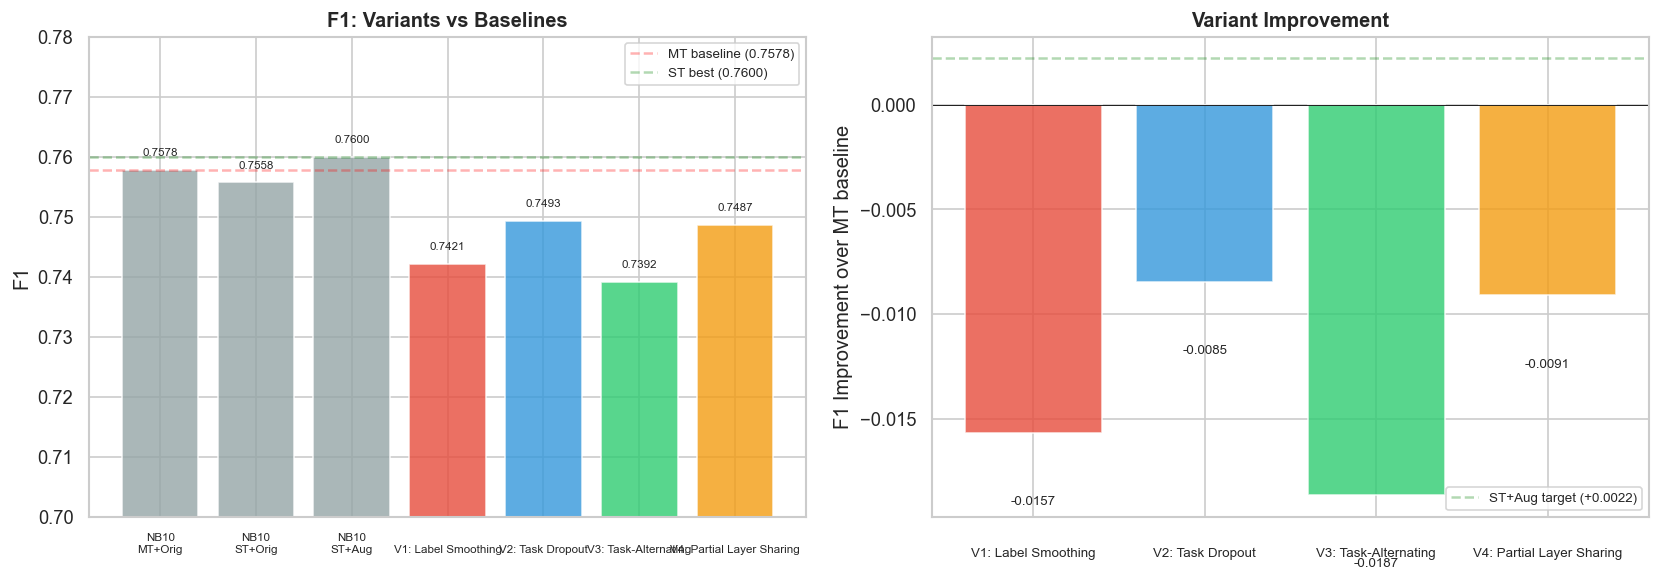

In [9]:
# Grouped bar chart: variants vs baselines
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: F1 comparison
names = ['NB10\nMT+Orig', 'NB10\nST+Orig', 'NB10\nST+Aug'] + \
        [rn.replace('V', '\nV') for rn in variant_results.keys()]
f1s = [mt_orig_f1, st_orig_f1, st_aug_f1] + \
      [r['best_f1'] for r in variant_results.values()]
colors = ['#95a5a6', '#95a5a6', '#95a5a6'] + \
         ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

bars = axes[0].bar(range(len(names)), f1s, color=colors, alpha=0.8)
for bar, f1 in zip(bars, f1s):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                 f'{f1:.4f}', ha='center', va='bottom', fontsize=7)
axes[0].axhline(mt_orig_f1, color='red', linestyle='--', alpha=0.3, label=f'MT baseline ({mt_orig_f1:.4f})')
axes[0].axhline(st_aug_f1, color='green', linestyle='--', alpha=0.3, label=f'ST best ({st_aug_f1:.4f})')
axes[0].set_xticks(range(len(names)))
axes[0].set_xticklabels(names, fontsize=7)
axes[0].set_ylabel('F1')
axes[0].set_title('F1: Variants vs Baselines', fontweight='bold')
axes[0].legend(fontsize=8)
axes[0].set_ylim(0.70, max(f1s) + 0.02)

# Right: Improvement over MT baseline
variant_names = list(variant_results.keys())
improvements = [variant_results[n]['best_f1'] - mt_orig_f1 for n in variant_names]
v_colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

bars2 = axes[1].bar(range(len(variant_names)), improvements, color=v_colors, alpha=0.8)
for bar, imp in zip(bars2, improvements):
    axes[1].text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 0.001 if imp >= 0 else bar.get_height() - 0.003,
                 f'{imp:+.4f}', ha='center', va='bottom' if imp >= 0 else 'top', fontsize=8)
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].axhline(st_aug_f1 - mt_orig_f1, color='green', linestyle='--', alpha=0.3,
                label=f'ST+Aug target ({st_aug_f1 - mt_orig_f1:+.4f})')
axes[1].set_xticks(range(len(variant_names)))
axes[1].set_xticklabels([n.replace('V', '\nV') for n in variant_names], fontsize=8)
axes[1].set_ylabel('F1 Improvement over MT baseline')
axes[1].set_title('Variant Improvement', fontweight='bold')
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

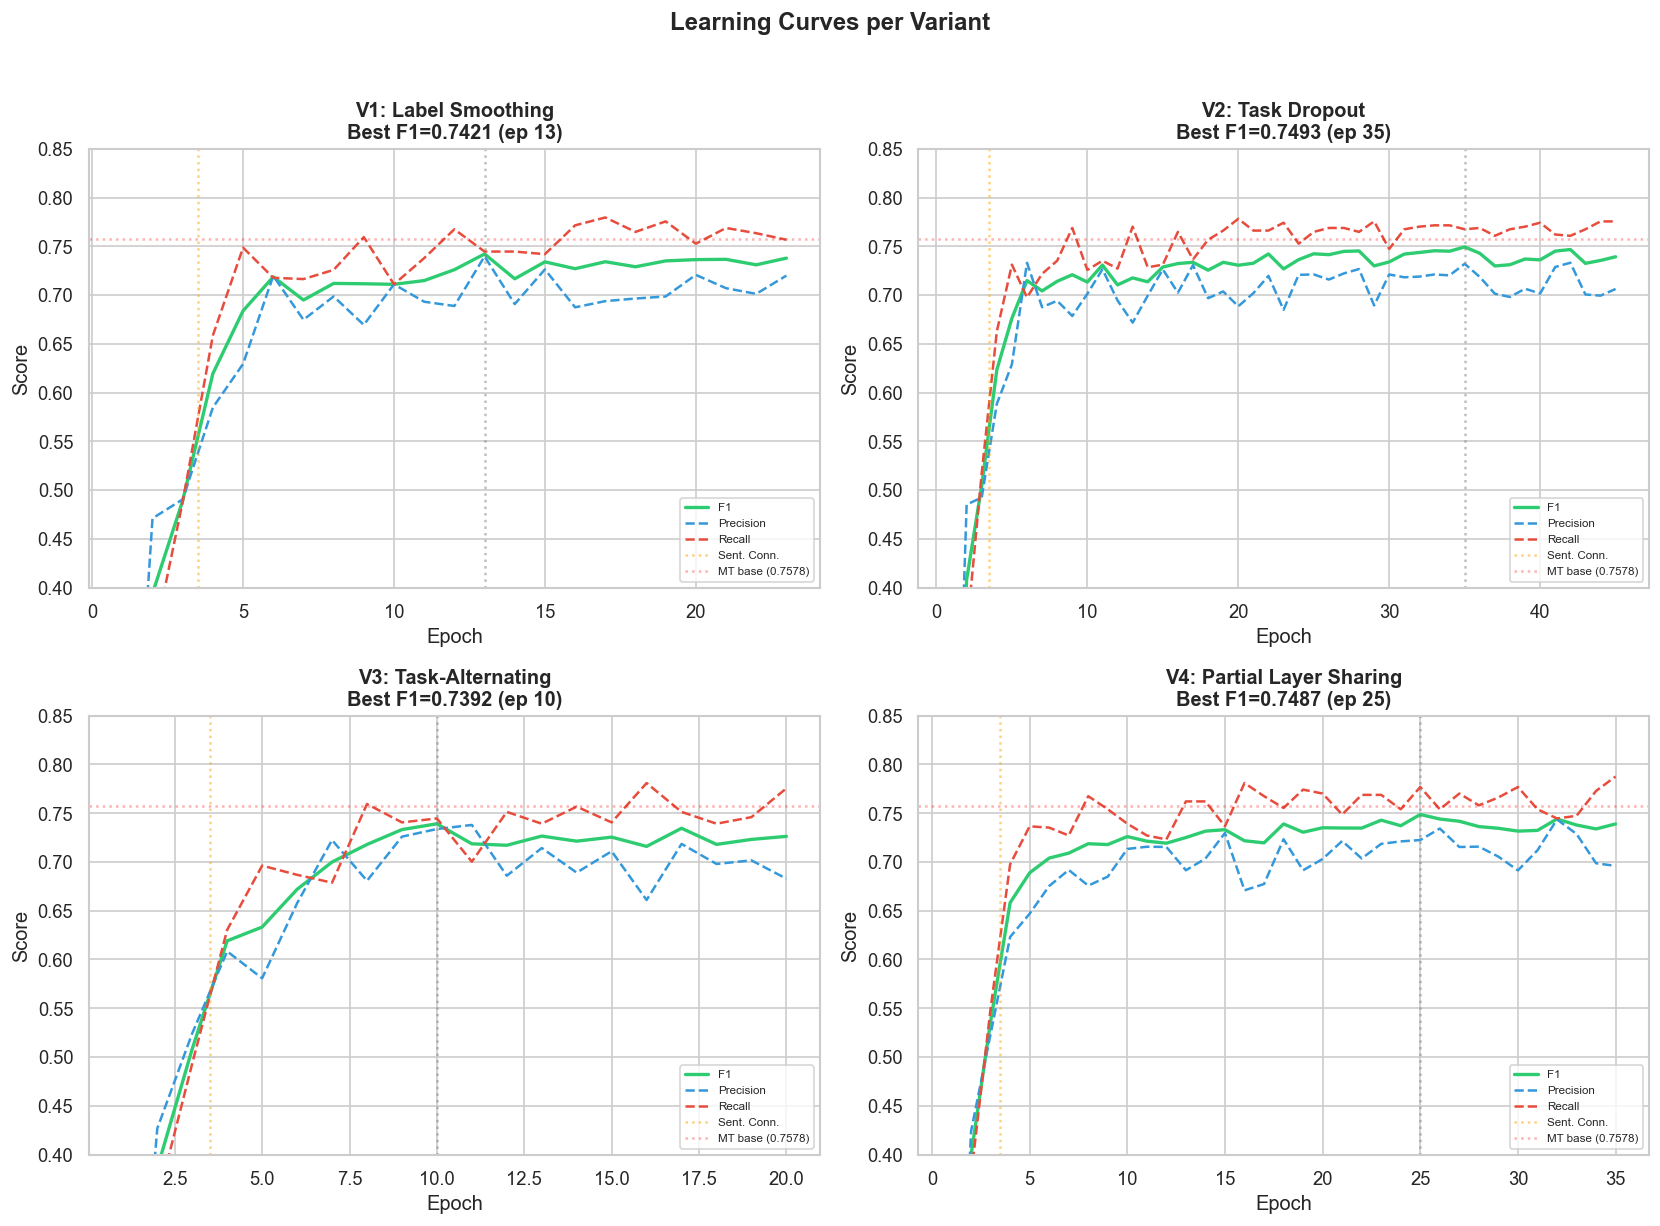

In [10]:
# Learning curves per variant (2x2)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (run_name, r) in enumerate(variant_results.items()):
    ax = axes[idx]
    h = r['history']
    epochs = range(1, len(h['val_f1']) + 1)

    ax.plot(epochs, h['val_f1'], label='F1', color='#2ecc71', linewidth=2)
    ax.plot(epochs, h['val_precision'], label='Precision', color='#3498db', linewidth=1.5, linestyle='--')
    ax.plot(epochs, h['val_recall'], label='Recall', color='#e74c3c', linewidth=1.5, linestyle='--')

    best_ep = r['best_epoch']
    ax.axvline(best_ep, color='gray', linestyle=':', alpha=0.5)
    ax.axvline(PHASE1_EPOCHS + 0.5, color='orange', linestyle=':', alpha=0.5, label='Sent. Conn.')
    ax.axhline(mt_orig_f1, color='red', linestyle=':', alpha=0.3, label=f'MT base ({mt_orig_f1:.4f})')

    ax.set_title(f'{run_name}\nBest F1={r["best_f1"]:.4f} (ep {best_ep})', fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Score')
    ax.legend(fontsize=7)
    ax.set_ylim(0.4, 0.85)

plt.suptitle('Learning Curves per Variant', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

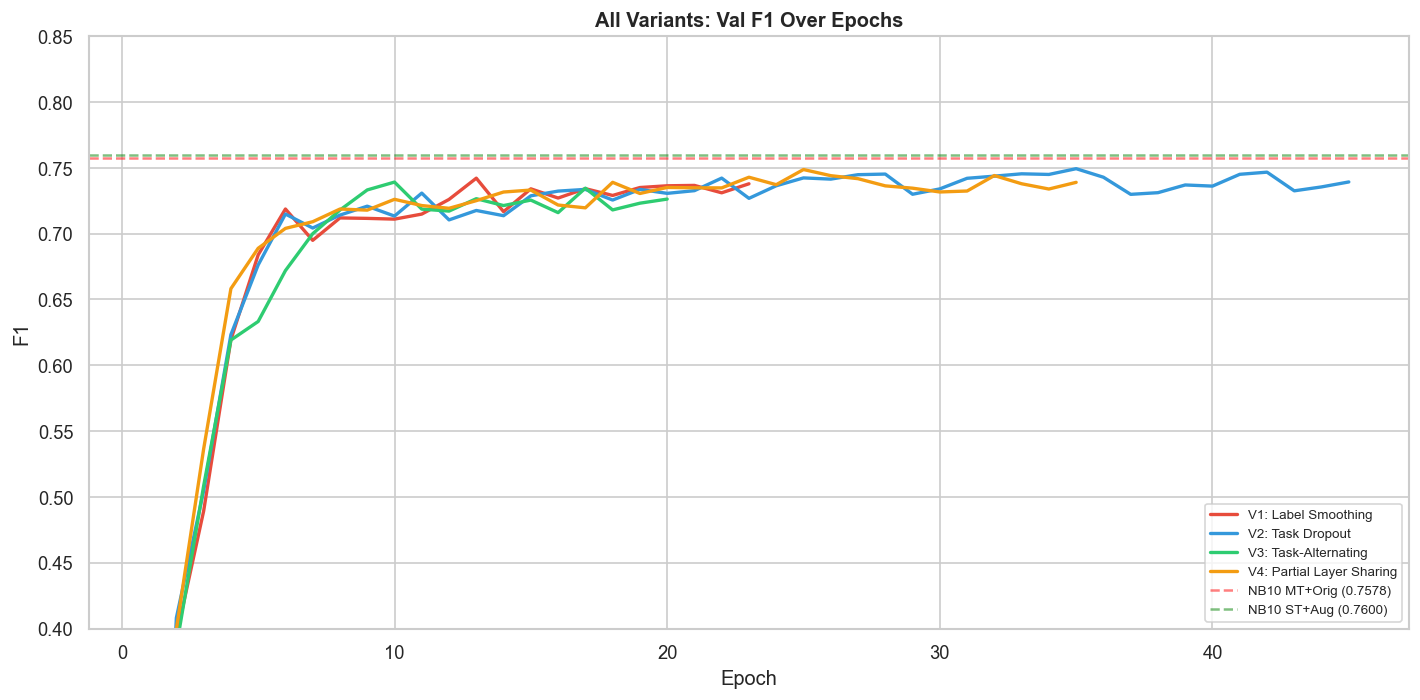

In [11]:
# All variant F1 curves overlaid
fig, ax = plt.subplots(figsize=(12, 6))
v_colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

for idx, (run_name, r) in enumerate(variant_results.items()):
    h = r['history']
    epochs = range(1, len(h['val_f1']) + 1)
    ax.plot(epochs, h['val_f1'], label=run_name, color=v_colors[idx], linewidth=2)

ax.axhline(mt_orig_f1, color='red', linestyle='--', alpha=0.5, label=f'NB10 MT+Orig ({mt_orig_f1:.4f})')
ax.axhline(st_aug_f1, color='green', linestyle='--', alpha=0.5, label=f'NB10 ST+Aug ({st_aug_f1:.4f})')
ax.set_title('All Variants: Val F1 Over Epochs', fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('F1')
ax.legend(fontsize=8)
ax.set_ylim(0.4, 0.85)

plt.tight_layout()
plt.show()

### 9. PER-CLASS COMPARISON

In [12]:
# Classification reports
for run_name, r in variant_results.items():
    print(f'\n{"="*60}')
    print(f'{run_name} (F1={r["best_f1"]:.4f}, Epoch {r["best_epoch"]})')
    print(f'{"="*60}')
    print(r['report'])

# Cross-variant per-class comparison
def extract_per_class_f1(report_str):
    result = {}
    for line in report_str.strip().split('\n'):
        line = line.strip()
        for cls in ['NEG', 'NEU', 'POS']:
            if line.startswith(cls):
                parts = line.split()
                result[cls] = {'precision': float(parts[1]), 'recall': float(parts[2]), 'f1': float(parts[3])}
    return result

print(f'\n{"="*80}')
print('PER-CLASS F1 COMPARISON (all variants + NB10 baselines)')
print(f'{"="*80}')
print(f'\n{"":>30s} {"NEG":>10s} {"NEU":>10s} {"POS":>10s} {"Overall":>10s}')
print('-' * 75)

# NB10 MT baseline
mt_cls = extract_per_class_f1(nb10_results['MT + Original']['report'])
print(f'{"NB10: MT + Original":>30s} {mt_cls["NEG"]["f1"]:>10.2f} {mt_cls["NEU"]["f1"]:>10.2f} '
      f'{mt_cls["POS"]["f1"]:>10.2f} {mt_orig_f1:>10.4f}')

# NB10 ST baseline
st_cls = extract_per_class_f1(nb10_results['ST + Original']['report'])
print(f'{"NB10: ST + Original":>30s} {st_cls["NEG"]["f1"]:>10.2f} {st_cls["NEU"]["f1"]:>10.2f} '
      f'{st_cls["POS"]["f1"]:>10.2f} {st_orig_f1:>10.4f}')

print('-' * 75)

# Variants
for run_name, r in variant_results.items():
    cls = extract_per_class_f1(r['report'])
    neg = cls.get('NEG', {'f1': 0})
    neu = cls.get('NEU', {'f1': 0})
    pos = cls.get('POS', {'f1': 0})
    print(f'{run_name:>30s} {neg["f1"]:>10.2f} {neu["f1"]:>10.2f} '
          f'{pos["f1"]:>10.2f} {r["best_f1"]:>10.4f}')


V1: Label Smoothing (F1=0.7421, Epoch 13)
              precision    recall  f1-score   support

         NEG       0.59      0.57      0.58        83
         NEU       0.58      0.61      0.59       125
         POS       0.80      0.80      0.80       536

   micro avg       0.74      0.74      0.74       744
   macro avg       0.66      0.66      0.66       744
weighted avg       0.74      0.74      0.74       744


V2: Task Dropout (F1=0.7493, Epoch 35)
              precision    recall  f1-score   support

         NEG       0.61      0.59      0.60        83
         NEU       0.57      0.67      0.62       125
         POS       0.79      0.82      0.81       536

   micro avg       0.73      0.77      0.75       744
   macro avg       0.66      0.69      0.67       744
weighted avg       0.74      0.77      0.75       744


V3: Task-Alternating (F1=0.7392, Epoch 10)
              precision    recall  f1-score   support

         NEG       0.62      0.53      0.57        83
  

### 10. SUBTASK LOSSES

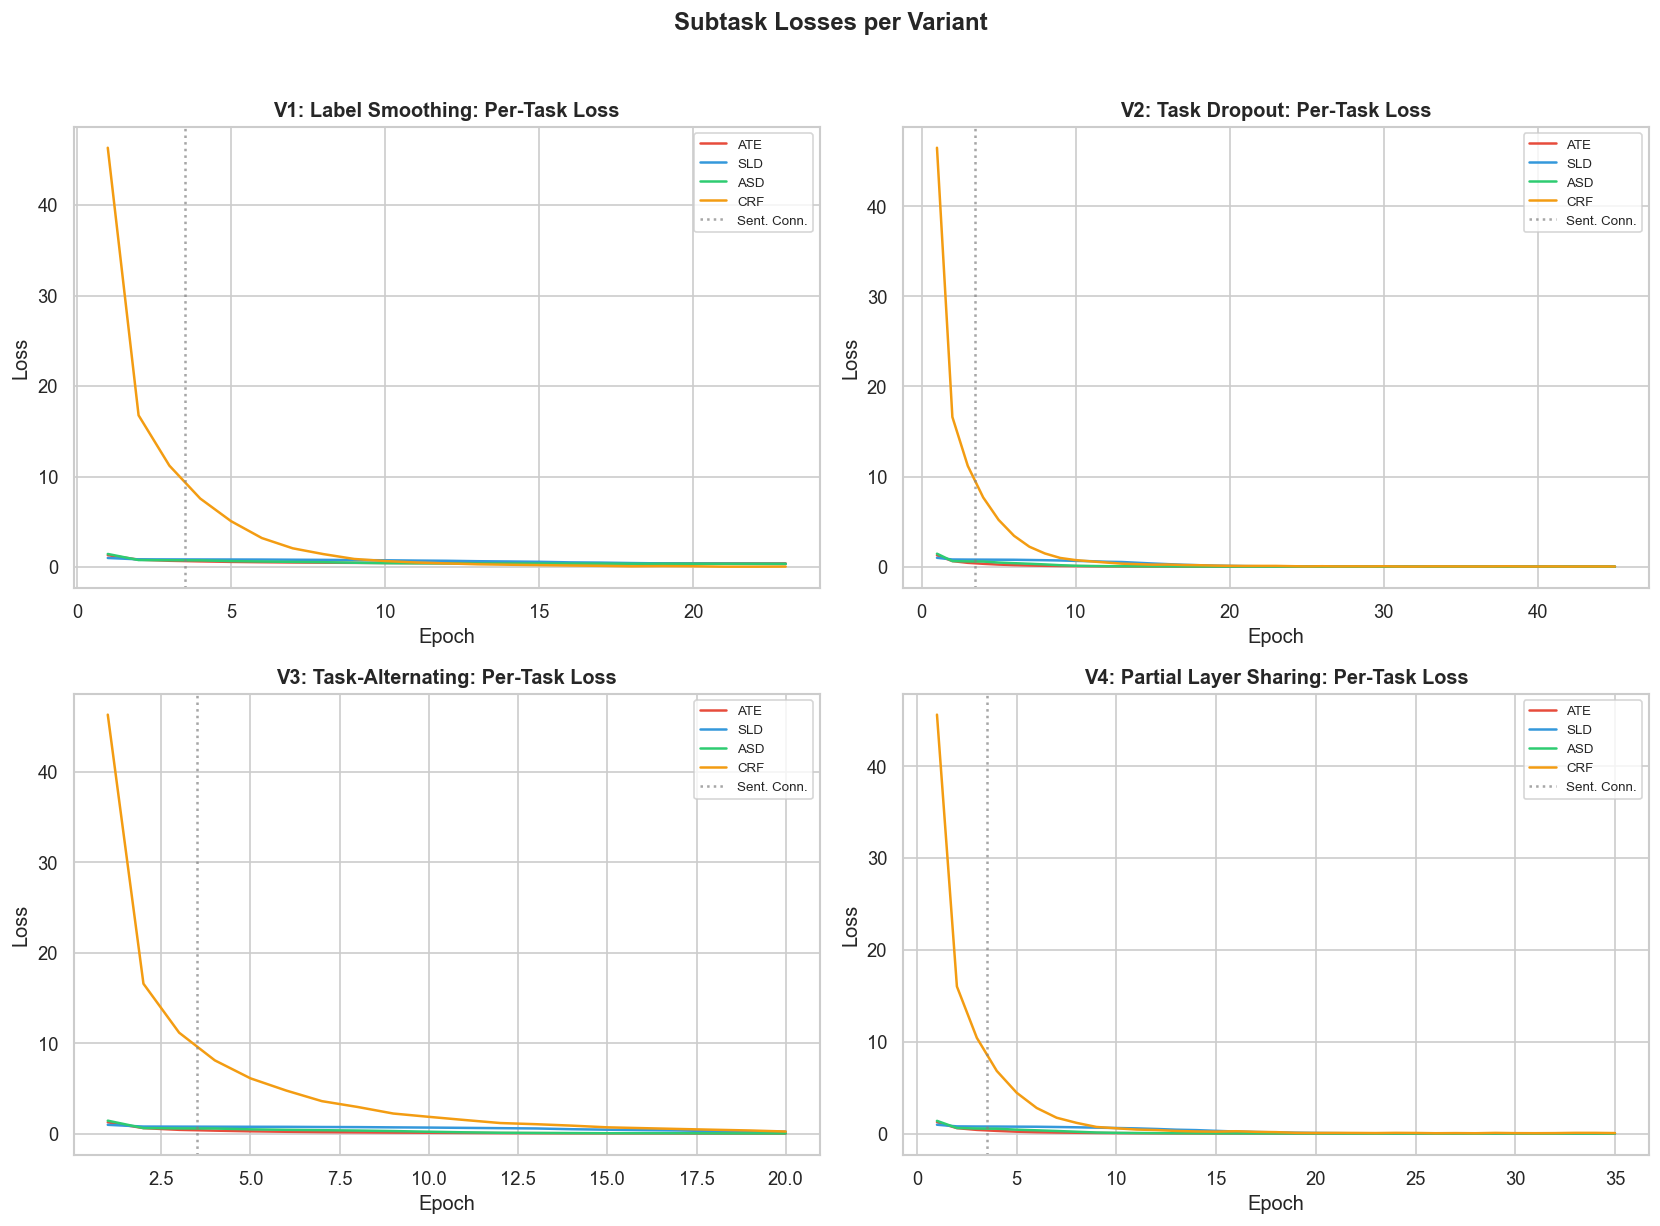

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
task_colors = {'ate': '#e74c3c', 'sld': '#3498db', 'asd': '#2ecc71', 'crf': '#f39c12'}

for idx, (run_name, r) in enumerate(variant_results.items()):
    ax = axes[idx]
    h = r['history']
    epochs = range(1, len(h['val_f1']) + 1)
    for task in ['ate', 'sld', 'asd', 'crf']:
        if f'loss_{task}' in h:
            ax.plot(epochs, h[f'loss_{task}'], label=task.upper(),
                    color=task_colors[task], linewidth=1.5)
    ax.axvline(PHASE1_EPOCHS + 0.5, color='gray', linestyle=':', alpha=0.7, label='Sent. Conn.')
    ax.set_title(f'{run_name}: Per-Task Loss', fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(fontsize=8)

plt.suptitle('Subtask Losses per Variant', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 11. KESIMPULAN

In [14]:
print('=' * 60)
print('KESIMPULAN: MTL ARCHITECTURE VARIANTS')
print('=' * 60)

# Ranking
all_models = {}
all_models['NB10: MT + Original'] = {'best_f1': mt_orig_f1, 'type': 'baseline'}
all_models['NB10: ST + Original'] = {'best_f1': st_orig_f1, 'type': 'baseline'}
all_models['NB10: ST + Augmented'] = {'best_f1': st_aug_f1, 'type': 'baseline'}
for name, r in variant_results.items():
    all_models[name] = {'best_f1': r['best_f1'], 'type': 'variant'}

sorted_models = sorted(all_models.items(), key=lambda x: x[1]['best_f1'], reverse=True)

print('\nRanking F1:')
for i, (name, info) in enumerate(sorted_models):
    marker = '*' if info['type'] == 'variant' else ' '
    print(f'  {i+1}. {marker} {name:<30s} F1={info["best_f1"]:.4f}')

# Analysis per variant
print(f'\nVariant Analysis (vs NB10 MT+Orig = {mt_orig_f1:.4f}):')
for name, r in variant_results.items():
    diff = r['best_f1'] - mt_orig_f1
    status = 'BETTER' if diff > 0 else 'WORSE' if diff < 0 else 'SAME'
    print(f'  {name:<30s}: {diff:+.4f} ({status})')

# Best variant interpretation
best_v_name = max(variant_results, key=lambda k: variant_results[k]['best_f1'])
best_v_f1 = variant_results[best_v_name]['best_f1']
print(f'\nBest variant: {best_v_name}')
print(f'  F1={best_v_f1:.4f} (vs MT baseline {mt_orig_f1:.4f}: {best_v_f1 - mt_orig_f1:+.4f})')
print(f'  vs ST+Aug ({st_aug_f1:.4f}): {best_v_f1 - st_aug_f1:+.4f}')

KESIMPULAN: MTL ARCHITECTURE VARIANTS

Ranking F1:
  1.   NB10: ST + Augmented           F1=0.7600
  2.   NB10: MT + Original            F1=0.7578
  3.   NB10: ST + Original            F1=0.7558
  4. * V2: Task Dropout               F1=0.7493
  5. * V4: Partial Layer Sharing      F1=0.7487
  6. * V1: Label Smoothing            F1=0.7421
  7. * V3: Task-Alternating           F1=0.7392

Variant Analysis (vs NB10 MT+Orig = 0.7578):
  V1: Label Smoothing           : -0.0157 (WORSE)
  V2: Task Dropout              : -0.0085 (WORSE)
  V3: Task-Alternating          : -0.0187 (WORSE)
  V4: Partial Layer Sharing     : -0.0091 (WORSE)

Best variant: V2: Task Dropout
  F1=0.7493 (vs MT baseline 0.7578: -0.0085)
  vs ST+Aug (0.7600): -0.0107


### 12. SIMPAN HASIL

In [15]:
checkpoint = {
    'variant_results': variant_results,
    'nb10_baselines': {
        'mt_orig_f1': mt_orig_f1,
        'st_orig_f1': st_orig_f1,
        'st_aug_f1': st_aug_f1,
    },
    'config': {
        'model_name': MODEL_NAME,
        'num_epochs': NUM_EPOCHS,
        'patience': PATIENCE,
        'dropout': DROPOUT,
        'weight_decay': WEIGHT_DECAY,
        'lr_bert': LR_BERT,
        'lr_head': LR_HEAD,
        'batch_size': BATCH_SIZE * GRADIENT_ACCUMULATION,
        'lambda1': LAMBDA1,
        'lambda2': LAMBDA2,
        'phase1_epochs': PHASE1_EPOCHS,
        'seed': SEED,
        'shared_until': SHARED_UNTIL,
    },
    'variants': {
        'V1': 'label_smoothing=0.1',
        'V2': 'head_dropout=0.2',
        'V3': 'task_alternating (even=ATE+SLD, odd=ASD+CRF)',
        'V4': f'partial_sharing (shared 0-{SHARED_UNTIL}, split {SHARED_UNTIL+1}-23)',
    },
}

save_path = os.path.join(MODEL_DIR, 'checkpoint_mtl_variants.pt')
torch.save(checkpoint, save_path)

file_size = os.path.getsize(save_path) / (1024**2)
print(f'Checkpoint saved: {save_path}')
print(f'File size: {file_size:.1f} MB')
print(f'\nBest variant: {best_v_name} (F1={best_v_f1:.4f})')

Checkpoint saved: d:\Kuliah\TA\Notebook\models\checkpoint_mtl_variants.pt
File size: 0.3 MB

Best variant: V2: Task Dropout (F1=0.7493)
